# Analyze Genome Pegasus workflow expansion

## Global Configurations

In [1]:
notebook_name = "genome-pegasus"

In [2]:
parquet_folder="/p/gpfs1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"

In [3]:
num_nodes = 32

In [4]:
import os
folder_size = 0
 
# get size
for path, dirs, files in os.walk(parquet_folder):
    for f in files:
        fp = os.path.join(path, f)
        folder_size += os.path.getsize(fp)

folder_size /=1024.0*1024.0*1024.0

# display size
print(f"parquet_folder size: {folder_size} GB")

parquet_folder size: 46.45897197443992 GB


## System Imports

In [5]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [6]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [7]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "06:00" # job time per node for worker
worker_queue = "pbatch" # queue to be used per worker
n_workers = 16 # number of workers to be used for analysis
import sys
python_exe=sys.executable
print(python_exe)

/usr/workspace/iopp/.conda/envs/jupyter/bin/python


In [8]:
if folder_size < node_memory/n_workers_per_node:
    use_local_cluster=True
else:
    use_local_cluster=False

In [9]:
use_local_cluster=False

Other configurations we can compute

In [10]:
import math
num_nodes = math.ceil(n_workers / n_workers_per_node)
host = socket.gethostname()
dashboard_address = '{}:8787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
executable = f"{python_exe}"
job_extra = [f'-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [11]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'],
                     #extra=[f"--nthreads 1", f"--nprocs 1"],
                     local_directory="/dev/shm",
                     job_extra = job_extra, 
                     use_stdin=True, host = host,dashboard_address = dashboard_address,
                     python=executable)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 1
#BSUB -G asccasc
#BSUB -q pbatch
#BSUB -W 06:00
#BSUB -o genome-pegasus.log
#BSUB -e genome-pegasus.log
JOB_ID=${LSB_JOBID%.*}

/usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.200:33139 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 60 --local-directory /dev/shm



### Dask Analysis Imports

In [12]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [13]:
if use_local_cluster:
    from dask.distributed import Client, LocalCluster
    #client = LocalCluster(processes=False, n_workers=1, threads_per_worker=n_workers)
    client = Client("tcp://127.0.0.1:44407")
else:
    client = Client(cluster)

In [14]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:8787/status,
Dashboard: http://192.168.66.200:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:33139,Workers: 0
Dashboard: http://192.168.66.200:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [15]:
if not use_local_cluster:
    cluster.scale(n_workers)

In [16]:
if not use_local_cluster:
    val = len(client.scheduler_info()["workers"])
    while ((client.status == "running") and ( val < n_workers)):
        print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
        sleep(1.0)
        val = len(client.scheduler_info()["workers"])
    print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

Waiting for workers completed 12 of 16
16 workers started


In [17]:

    print("\n{} workers started".format(len(client.scheduler_info()["workers"])))


16 workers started


## Analysis Utility Functions

### Progress Bars

In [18]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [19]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [20]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

## Initial Boostrapping

### Read Application logs into dask dataframe

In [21]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [22]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 51 partitions


In [23]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'proc', 'rank', 'thread_id', 'cat', 'tstart', 'tend',
       'func_id', 'level', 'hostname', 'arg_count', 'app', 'args_1', 'args_2',
       'args_3', 'args_4', 'args_5', 'args_6', 'args_7', 'args_8', 'args_9',
       'args_10'],
      dtype='object')


In [24]:
ddf.dtypes

index          int64
proc           int64
rank           int32
thread_id      int32
cat            int32
tstart       float32
tend         float32
func_id       object
level          int32
hostname      object
arg_count      int32
app           object
args_1        object
args_2        object
args_3        object
args_4        object
args_5        object
args_6        object
args_7        object
args_8        object
args_9        object
args_10       object
dtype: object

In [ ]:
ddf.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,53431,0,315008,0,0.237784,0.237786,getcwd,0,lassen72,...,%p,4096,,,,,,,,
1,2,53431,0,315008,0,0.250517,0.250523,closedir,0,lassen72,...,%p,,,,,,,,,
2,3,53431,0,315008,0,0.250669,0.250673,opendir,0,lassen72,...,/g/g92/haridev/.openmpi/components,,,,,,,,,
3,4,53431,0,315008,0,0.291718,0.291721,getcwd,0,lassen72,...,%p,4096,,,,,,,,
4,5,53431,0,315008,0,0.295864,0.295868,closedir,0,lassen72,...,%p,,,,,,,,,


In [ ]:
ddf['app'].head()

0    pegasus-mpi-cluster
1    pegasus-mpi-cluster
2    pegasus-mpi-cluster
3    pegasus-mpi-cluster
4    pegasus-mpi-cluster
Name: app, dtype: object

#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [ ]:
ddf = ddf[(ddf['level'] == 0)]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [ ]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

### Preload the I/O dataframe for faster analysis

In [29]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Check I/O interfaces used by application

In [30]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0       getcwd
1     closedir
2      opendir
3        mkdir
4      fopen64
5       fileno
6       fclose
7       access
8       unlink
9        umask
10     readdir
11     __xstat
12        open
13    __fxstat
14       lseek
15        read
16       close
17    readlink
18       ftell
19       fread
20       write
21    __lxstat
22       fcntl
23       rmdir
24       chmod
Name: func_id, dtype: object


Only POSIX interface is used in this application

### Set duration of I/O events

In [31]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart'] + 0.0000001

In [32]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [33]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [34]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [35]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

In [36]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [39]:
io_ddf_read_write = io_ddf[read_condition | write_condition | fread_condition | fwrite_condition].compute()

In [ ]:
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv","fread"])
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev","fwrite"])
data_ops = ['read', 'write']
total_time_io_data = io_ddf[ read_condition | write_condition ].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~(read_condition | write_condition)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [40]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [41]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [42]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [43]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [44]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [45]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [46]:
all_filenames = io_ddf_read_write[io_ddf_read_write['filename'].str.contains('/p/gpfs1')]['filename'].unique()

In [47]:
filename_series = io_ddf_read_write[io_ddf_read_write['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['proc'].nunique()

In [48]:
time_step=1000 # in seconds

In [49]:
job_time = ddf['tend'].max().compute()

In [50]:
rank_index_series = io_ddf_read_write.groupby(['hostname','app','proc','rank', 'thread_id'])['thread_id'].nunique().cumsum()
num_ranks = rank_index_series.nunique()

In [51]:
app_str = io_ddf_read_write['app'].unique()

In [52]:
thread_index_series = io_ddf.groupby(['proc', 'thread_id'])['thread_id'].nunique().cumsum().compute()
proc_index_series = io_ddf.groupby(['hostname','proc'])['thread_id'].nunique().cumsum().compute()

In [51]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

The application accesses 10662475 files across all ranks


In [52]:
io_ddf_read_write.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_6,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth
194645,194646,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0
194651,194652,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,4977,1,0.0
194652,194653,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,1,1,0.0
194661,194662,53803,0,31131248,0,109598.578125,109598.578125,fread,0,lassen72,...,,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,2,1,0.0
203009,203010,53803,0,31131248,0,109617.867188,109617.867188,read,0,lassen72,...,,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,8192,1,0.0


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [53]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,5.377495e+08,5.377495e+08
mean,1.457776e+05,2.412548e-02
std,1.512329e+06,5.313088e+00
min,1.000000e+00,0.000000e+00
25%,8.192000e+03,0.000000e+00
50%,8.192000e+03,0.000000e+00
75%,8.192000e+03,0.000000e+00
max,1.677722e+07,2.048000e+03


### Preload the I/O dataframe for faster analysis

In [ ]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Operations Per Application

In [49]:
io_ddf.groupby(['app','func_id'])['func_id'].count().compute()

app               func_id 
individuals       __fxstat    8207918
                  __lxstat    4102322
                  __xstat       37651
                  close       8206281
                  closedir      43216
                               ...   
mutation_overlap  opendir         470
                  read          84113
                  readdir     1942257
                  readlink         56
                  write        140952
Name: func_id, Length: 116, dtype: int64

In [50]:
io_ddf_read_write.groupby(['app','func_id'])['size'].sum() /1024.0/1024.0

app                func_id
frequency          fread      1.182556e-04
                   read       4.001546e+06
                   write      4.820506e+04
individuals        fread      3.122330e-03
                   read       6.853469e+07
                   write      5.237581e+03
individuals_merge  fread      1.907349e-05
                   read       2.067921e+06
                   write      1.684458e+04
mutation_overlap   fread      1.068115e-04
                   read       3.814787e+04
                   write      4.169359e+04
sifting            fread      9.536743e-06
                   read       5.976248e+03
                   write      3.755455e+00
Name: size, dtype: float64

In [51]:
io_ddf_read_write['app'].unique() 

array(['individuals', 'sifting', 'individuals_merge', 'frequency',
       'mutation_overlap'], dtype=object)

In [52]:
io_ddf_read_write.groupby(['app'])['proc'].nunique() 

app
frequency              62
individuals          1632
individuals_merge      10
mutation_overlap       56
sifting                 5
Name: proc, dtype: int64

## Application Analysis

In [53]:

#io_ddf_read_write['rank_index'] = 0
#for index,item in rank_index_series.iteritems():
#    condition = (io_ddf_read_write['hostname'] == index[0]) & (io_ddf_read_write['app'] == index[1]) & (io_ddf_read_write['proc'] == index[2]) & (io_ddf_read_write['rank'] == index[3]) & (io_ddf_read_write['thread_id'] == index[4])
#    io_ddf_read_write['rank_index'] = io_ddf_read_write['rank_index'].mask(condition , item - 1)

### Num Ranks

In [54]:

print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 1770


### Total I/O amount

In [55]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 73008.06977906171 GB
Total I/O per operation in application func_id
fread        0.000003
read     72898.709843
write      109.359933
Name: size, dtype: float64 GB


### I/O per rank

In [56]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     fread      3.540000e+03
      read       7.827439e+13
      write      1.174243e+11
Name: size, dtype: float64

**rank 0 performs 100x more I/O than others. Also every other process reads data where as only rank 0 writes it.**

<AxesSubplot:xlabel='app'>

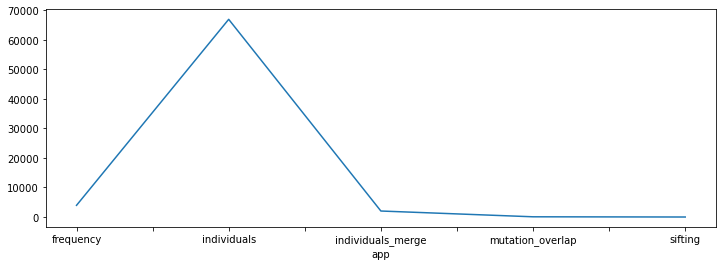

In [57]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['size'].sum()/1024.0/1024.0/1024.0
io_per_rank_gb.plot(kind='line',figsize=(12,4))

### Operations Per Rank

<AxesSubplot:xlabel='app'>

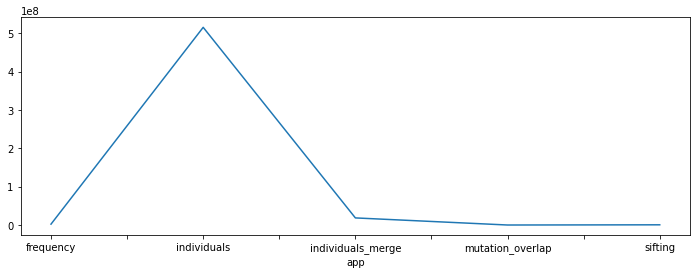

In [58]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(12,4))

**Also rank 0 performs 2000x more operations than other ranks.**

### Average I/O Time per process

In [59]:
time_per_rank = io_ddf.groupby('app')['duration'].sum().compute()

In [60]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 19105.37109375 sec, Max 116047.5078125 sec, and Min 14.231298446655273 sec


<AxesSubplot:xlabel='app'>

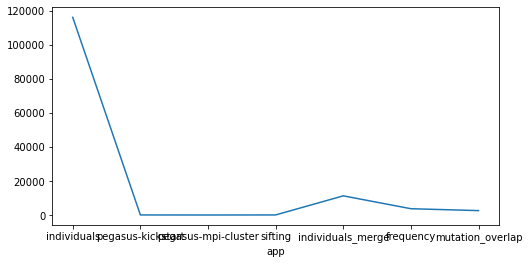

In [61]:
time_per_rank.plot(kind='line',figsize=(8,4))

Most time is spent by rank 0.

### Compute Time

#### Convert trace dataframe into memory.

In [62]:
trace_ddf_local = trace_ddf

#### Calculate duration for trace values

In [63]:
trace_ddf_local['duration'] = trace_ddf_local['tend'] - trace_ddf_local['tstart']

In [64]:
#trace_ddf_local['duration'].describe().compute()

In [65]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count().compute()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 0 negetive rows


In [66]:
time_per_rank = trace_ddf_local.groupby('app')['duration'].sum().compute()

In [67]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average nan sec, Max nan sec, and Min nan sec


<AxesSubplot:xlabel='app'>

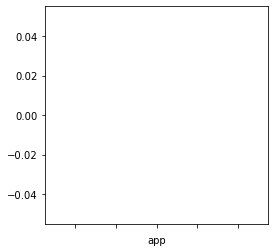

In [68]:
time_per_rank.plot(kind='line',figsize=(4,4))

**No compute trace available**

## Job Time

In [70]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 289629.15625 sec


The application run for a long time includes initialization.

## Job Intensity

In [71]:
total_compute = trace_ddf_local['duration'].sum().compute()
total_io = io_ddf['duration'].sum().compute()
print("I/O Time: {} sec Compute Time: {} sec".format(total_io, total_compute))

I/O Time: 133737.59375 sec Compute Time: 0.0 sec


In [72]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [73]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: 1.0, Compute intensity: 0.0


**Application is not compute intensive as only 4 second of the overall time (i.e. 668 sec) is spent on I/O**

### I/O Transfer Size Distribution

[10269390, 522709461, 360770, 215, 4409693]


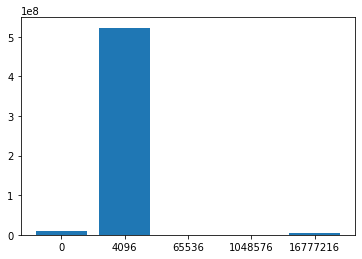

In [74]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

**Application performs a lot of small I/O <=4 KB and reads 16MB**

### Distribution of request sizes per rank
We need this as we see most I/O occurs by rank 0

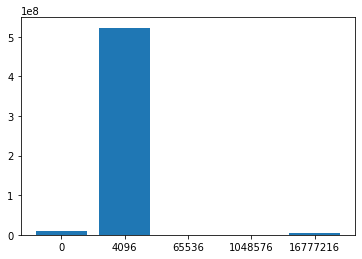

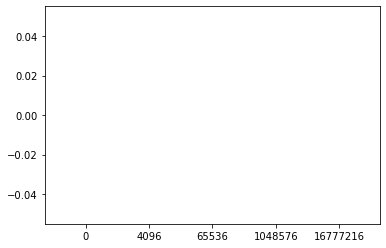

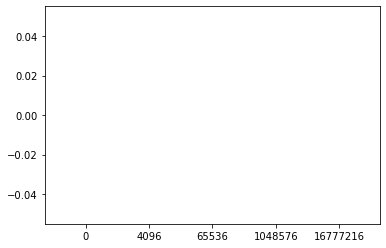

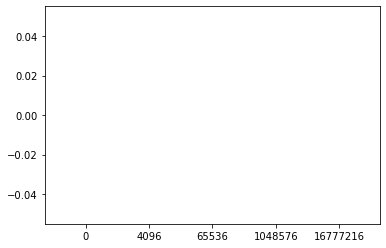

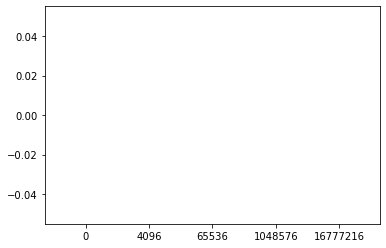

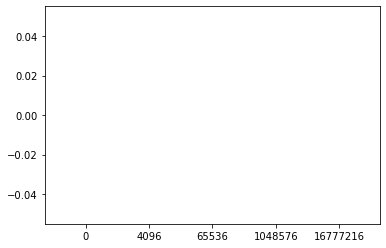

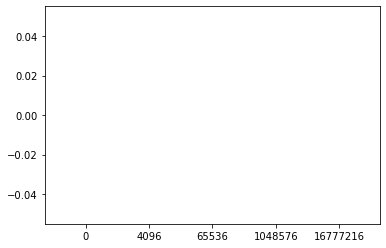

In [75]:
selected_ranks = [0,1,2,3,4,5,6]
for rank in selected_ranks:
    file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
    size_ranges_str = []
    for range_val in size_ranges:
        size_ranges_str.append(str(range_val))
    max_range = len(size_ranges)
    request_size = [0]*len(size_ranges)
    for i, val in enumerate(size_ranges):
        #print(i, max_range)
        if i < max_range - 1:
            request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
        else:
            request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

    #print(request_size)
    plt.bar(size_ranges_str, request_size)
    #file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    #plt.hist(file_sizes, bins=100)
    plt.show()

**The application uses a transfer size of 4K (used by rank 0) and 16MB (used by other ranks)**

### Distribution of Bandwidth achived by application

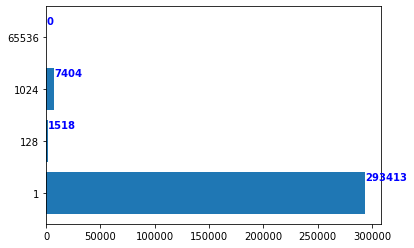

In [76]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
file_df_temp = io_ddf_read_write
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [77]:
request_bw

[293413, 1518, 7404, 0]

In [78]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([97.04896886,  0.50209205,  2.44893909,  0.        ])

- 40% of the overall I/O got a bandwidth of 128 MB/s per process.
- 35% achieve a low bandwidth of 64GB/s

0.0008817370807393875 0.00020119908879503548


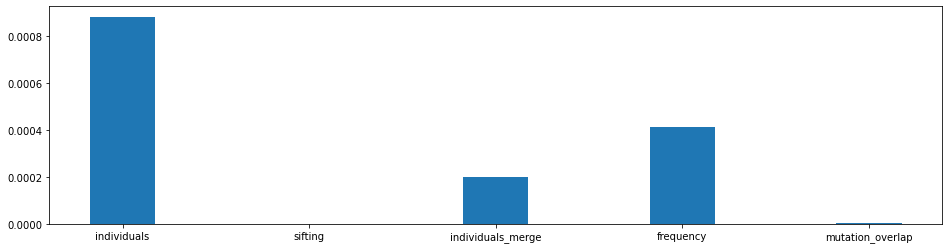

0.0007040018211235149 0.0007040018211235149


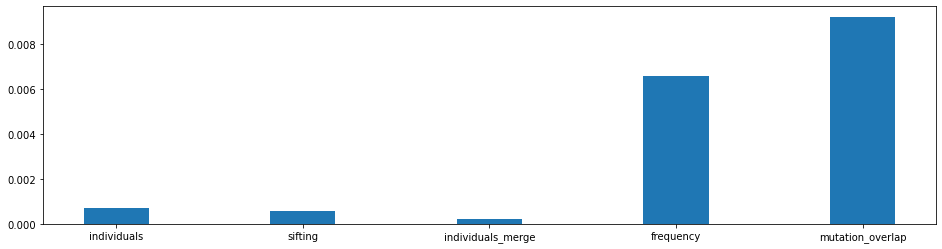

0.47000697914545864 0.7259725333097372


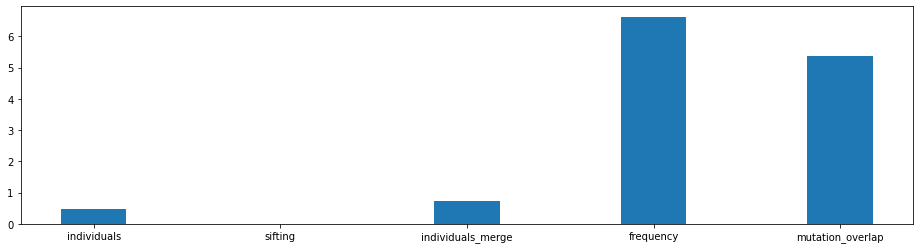

nan nan


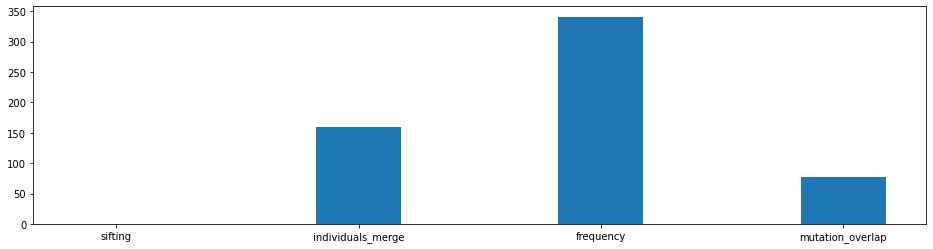

1.6184447607380117 4.336426927973102


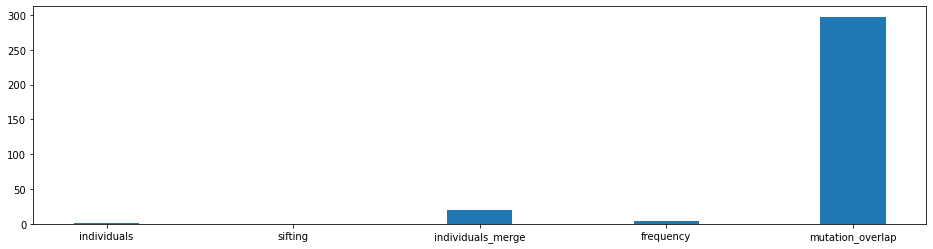

No handles with labels found to put in legend.


In [79]:

size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.median(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

### Number of files read/written

In [80]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 10662475 files


### I/O Operations by Application

In [81]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
__fxstat     21700716
__lxstat      4378914
__xstat       6607882
access           1193
close        21655449
closedir      1702244
fclose           1771
fcntl            4146
fileno           5428
fopen64          1771
fread            1770
ftell            1770
getcwd        4384604
lseek        26197921
mkdir            7481
open         21655449
opendir         15723
read        526988264
readdir      63100423
readlink         1770
rmdir            4146
umask            1912
unlink           2563
write        10759495
chmod         6555585
Name: func_id, dtype: int64

**As there are 1280 ranks in total, Most I/O is performed by rank 0 rest of them do less I/O**

### IO Operations per rank

In [82]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:32]

rank  func_id 
0     __fxstat     21700716
      __lxstat      4378914
      __xstat       6607882
      access           1193
      close        21655449
      closedir      1697128
      fclose           1771
      fcntl            4146
      fileno           5428
      fopen64          1771
      fread            1770
      ftell            1770
      getcwd        4382046
      lseek        26197921
      mkdir            7357
      open         21655449
      opendir         13165
      read        526988264
      readdir      63100423
      readlink         1770
      rmdir            4146
      umask            1912
      unlink           2563
      write        10759495
1     closedir            4
      getcwd              2
      opendir             2
2     closedir            4
      getcwd              2
      opendir             2
3     closedir            4
      getcwd              2
Name: func_id, dtype: int64

In [83]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[128:160]

rank  func_id 
35    opendir     2
36    closedir    4
      getcwd      2
      opendir     2
37    closedir    4
      getcwd      2
      opendir     2
38    closedir    4
      getcwd      2
      opendir     2
39    closedir    4
      getcwd      2
      opendir     2
40    closedir    4
      getcwd      2
      mkdir       4
      opendir     2
41    closedir    4
      getcwd      2
      opendir     2
42    closedir    4
      getcwd      2
      opendir     2
43    closedir    4
      getcwd      2
      opendir     2
44    closedir    4
      getcwd      2
      opendir     2
45    closedir    4
      getcwd      2
      opendir     2
Name: func_id, dtype: int64

**These confirm our hypothesis that most I/O is performed by rank 0 rest of them do less I/O**

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

0.0014987795459558931


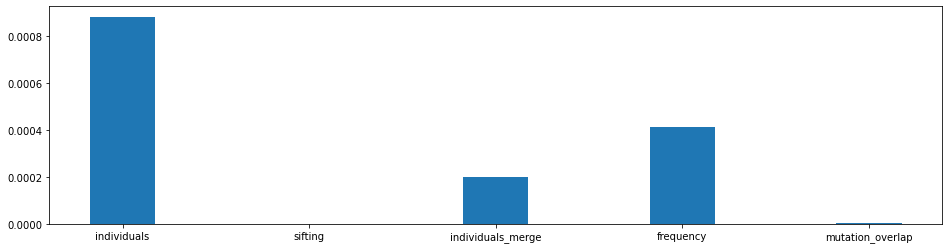

0.01731446648857357


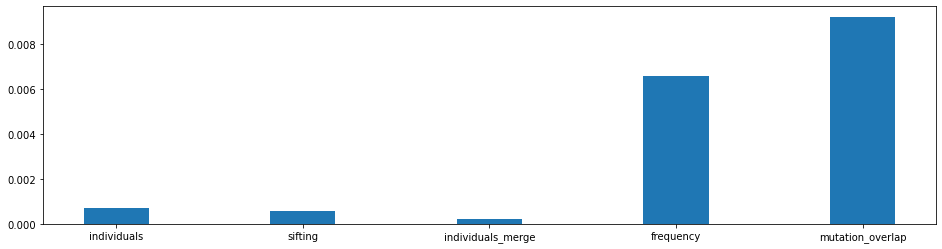

13.19557215743238


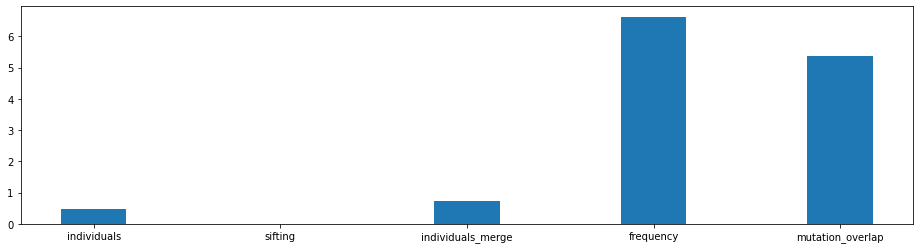

nan


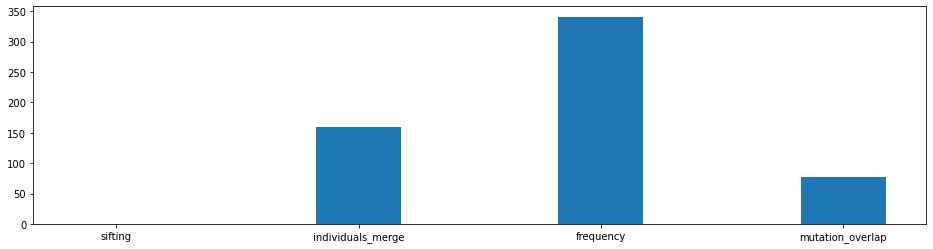

323.1912182714274


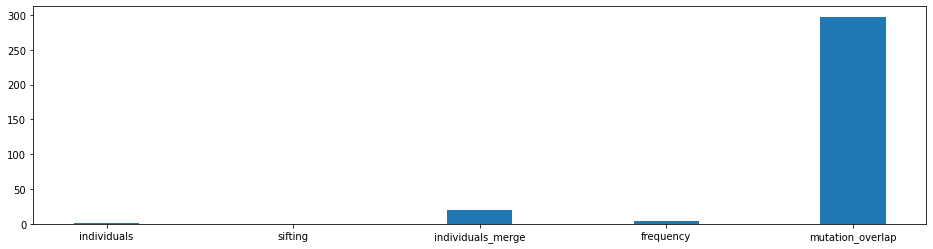

No handles with labels found to put in legend.


In [84]:
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(np.sum(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

**Larger Request sizes have larger bandwidth. However as 4KB write dominates the application I/O we see small bandwidth overall**

### Overlapping of Compute and I/O

In [85]:
io_ddf.groupby('proc')['thread_id'].nunique().describe().compute()

count    2701.000000
mean        1.006664
std         0.081377
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [86]:
time_step=1000 # in seconds

#### Request Size Timeline

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3809075448662043, 48.656868050806224, 170.79115983564407, 251.45499523635954, 330.9182542897761, 363.5845740325749, 439.61534353066236, 439.23231174144894, 562.9997022962198, 638.1375944148749, 634.9973754100502, 663.4564462406561, 617.1592337833717, 654.9380473736674, 597.4247957272455, 738.2797738080844, 773.0358353583142, 743.9674246180803, 643.1623307969421, 682.0982504989952, 787.6848427681252, 744.8636749582365, 743.9074694244191, 684.5171343209222, 758.4141514478251

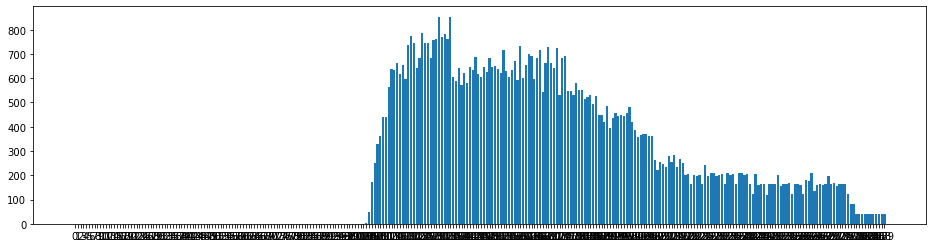

In [87]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.380719054490328, 48.647845700383186, 170.76849859207869, 251.43043413758278, 330.889207880944, 363.5570989921689, 439.5862419344485, 439.1970695108175, 560.8344513727352, 635.1021265853196, 632.6343559594825, 661.080535242334, 614.2943090396002, 652.5213691871613, 594.7642499404028, 735.0748739643022, 771.3254536604509, 741.710313254036, 640.3478983733803, 679.9256302444264, 784.51666261442, 741.7164603732526, 742.5708460155874, 682.2513423953205, 754.0523643838242, 758.77

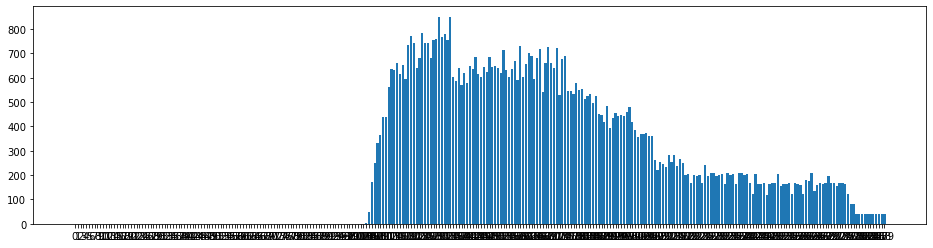

In [88]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & (fread_condition | read_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001884903758764267, 0.009022350423038006, 0.022661243565380573, 0.024561098776757717, 0.02904640883207321, 0.027475040405988693, 0.0291015962138772, 0.035242230631411076, 2.165250923484564, 3.035467829555273, 2.3630194505676627, 2.3759109983220696, 2.864924743771553, 2.416678186506033, 2.660545786842704, 3.2048998437821865, 1.7103816978633404, 2.257111364044249, 2.8144324235618114, 2.1726202545687556, 3.1681801537051797, 3.1472145849838853, 1.336623408831656, 2.2657919256

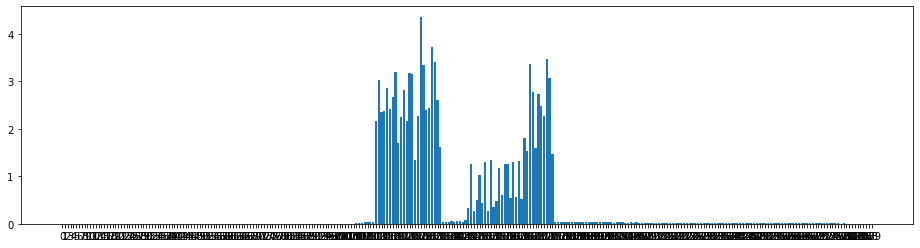

In [89]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & (fwrite_condition | write_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**Most of the I/O (20GB) is performed in first 40 seconds and rest 1GB happens in the rest of the time**

### Time Timeline

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.359375, 12.1015625, 25.195312, 35.921875, 43.25, 42.257812, 60.085938, 65.015625, 130.64062, 154.67969, 196.02344, 159.49219, 133.39844, 118.65625, 117.578125, 160.78906, 124.75781, 134.92969, 180.61719, 166.60156, 122.421875, 184.94531, 134.75781, 179.85156, 237.25781, 242.60938, 175.69531, 181.53906, 205.61719, 214.03125, 192.21875, 92.359375, 67.703125, 64.953125, 59.90625, 61.0625, 53.0625, 64.359375, 68.234375, 73.421875, 59.96875, 71.078125, 89.796875, 72.84375, 80.6

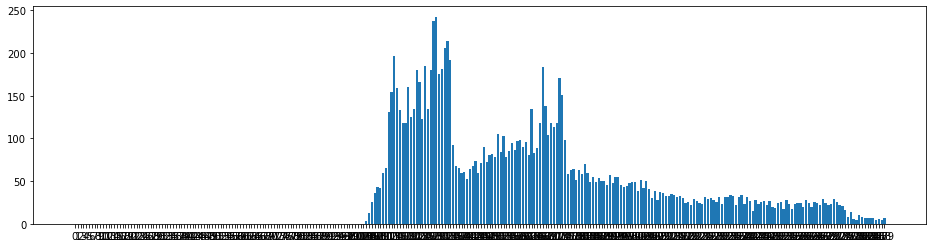

In [90]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['duration'].sum()
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

#### Bandwidth Timeline

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.3519870664631216e-06, 1.2342259357922611e-05, 2.066382308240996e-05, 3.0079013803154056e-05, 3.7309758204925586e-05, 3.4004510122585864e-05, 2.4776806512403175e-05, 2.2767870935136846e-05, 5.7505065989029995e-05, 6.0163805874878995e-05, 6.350648916067445e-05, 6.36199417233735e-05, 5.582337870836648e-05, 5.93898928495522e-05, 4.8100954910574804e-05, 6.126254227603196e-05, 7.277941018515563e-05, 5.2130637875957e-05, 7.512881244284312e-05, 6.101182581191162e-05, 5.51032569359

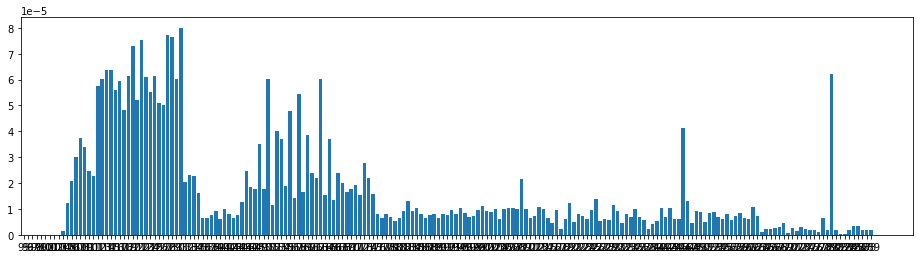

In [91]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.351432132476992e-06, 1.2393854717972739e-05, 2.0798214608480445e-05, 3.030487737728289e-05, 3.761792541276238e-05, 3.4234128709521344e-05, 2.494402581684039e-05, 2.29210443004391e-05, 4.280990647950447e-05, 4.452360008052282e-05, 4.6743491626118365e-05, 4.5824233004740414e-05, 3.6862324810179675e-05, 4.36552461042112e-05, 3.64881278148096e-05, 4.877469626173966e-05, 6.234430496222489e-05, 4.34692100253472e-05, 5.789163964209141e-05, 4.8936218495056155e-05, 4.36723565747672

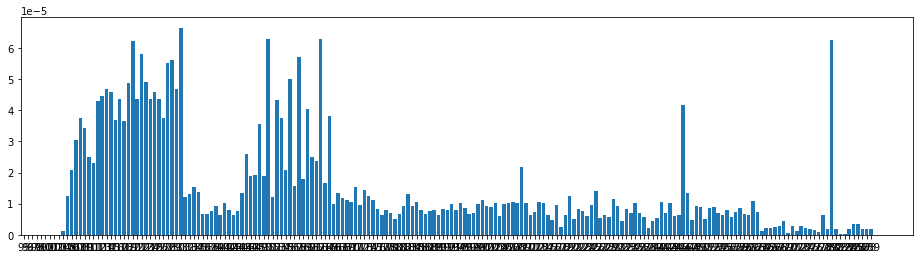

In [92]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & ( fread_condition | read_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 2.86102294921875e-06, 2.5563577789693294e-06, 3.3020533977326267e-06, 2.4002118519832763e-06, 2.3410819282512694e-06, 2.458940135474168e-06, 1.6387664204143573e-06, 2.2068073440838793e-06, 0.0015137420306260306, 0.001258789342399712, 0.0018548751463714598, 0.0016463463354227362, 0.0016405605613045578, 0.0013916668665066, 0.0010646061142132292, 0.001142632522024607, 0.0010376121170704126, 0.000845285253212426, 0.0016201794869965672, 0.0012326968340278586, 0.001077640664189906

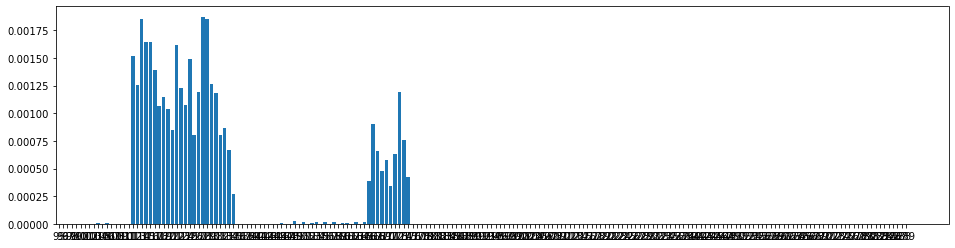

In [93]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & (fwrite_condition | write_condition)
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**This supports our previous observation as the bandwidth is the measure of I/O performance of the application.**

#### Bandwidth Timeline Per Rank

app individuals


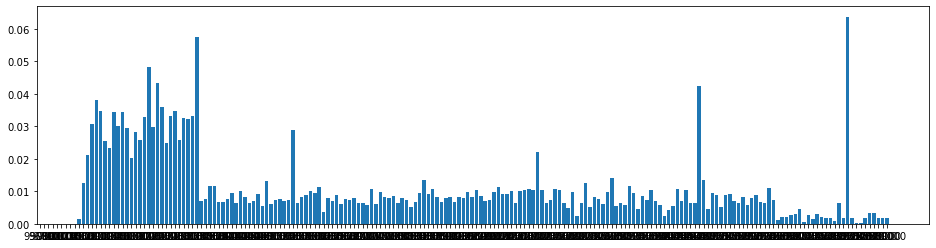

<Figure size 1152x288 with 0 Axes>

app sifting


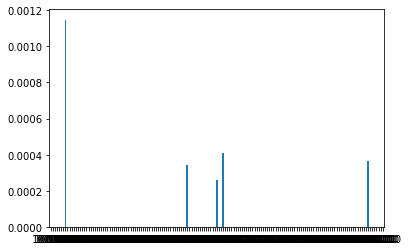

<Figure size 1152x288 with 0 Axes>

app individuals_merge


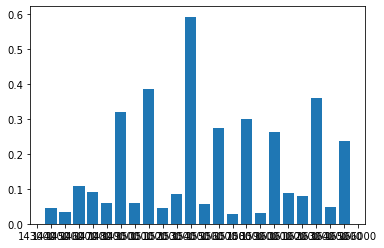

<Figure size 1152x288 with 0 Axes>

app frequency


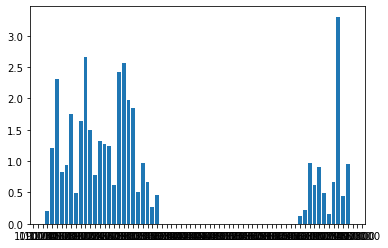

<Figure size 1152x288 with 0 Axes>

app mutation_overlap


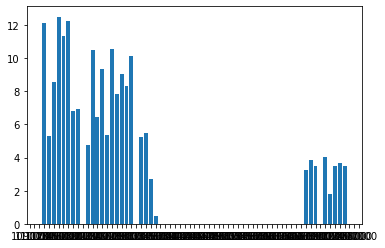

<Figure size 1152x288 with 0 Axes>

In [53]:
import math

selected_app = app_str

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(values[i]))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    print("app {}".format(app))
    plt.bar(value_str, timeline_ts)
    plt.figure(figsize=(16,4))
    plt.show()

**Most I/O happens in the first 40 sec and most bandwidth is achieved from PFS**

#### Request Size Timeline per Rank

app individuals


<Figure size 1152x288 with 0 Axes>

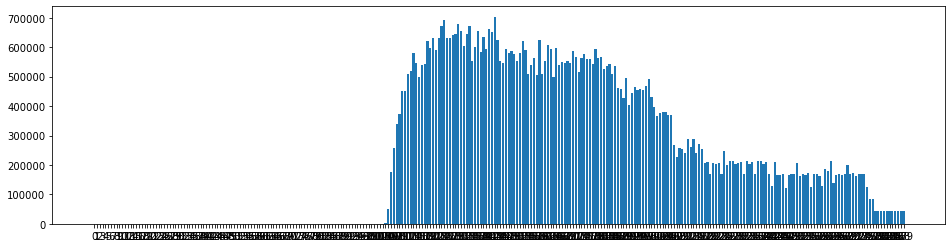

app sifting


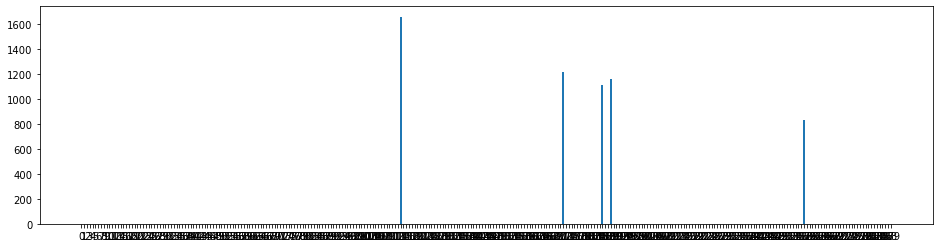

app individuals_merge


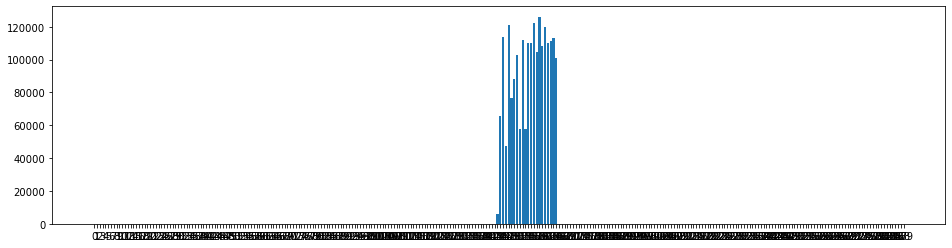

app frequency


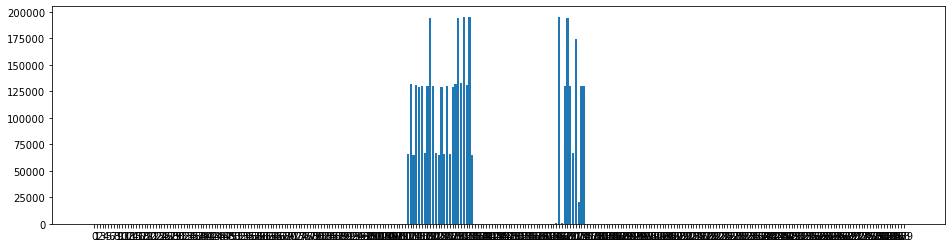

app mutation_overlap


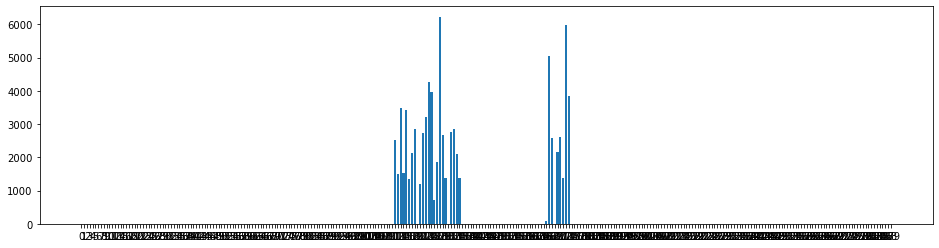

In [66]:
import math
selected_app = app_str

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(i))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()/1024.0/1024.0
        prev = values[i]
    print("app {}".format(app))
    plt.figure(figsize=(16,4))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Only rank 0 does I/O throughout the time. Rest perform read in first 40 seconds and perform computations.** 

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [59]:
#io_ddf['thread_index'] = 0
#for index,item in thread_index_series.iteritems():
#    condition = (io_ddf['proc'] == index[0]) & (io_ddf['thread_id'] == index[1])
#    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [60]:
num_procs = proc_index_series.count()
threads = thread_index_series.count()
print("We have {} threads across {} process".format(threads, num_procs))

We have 2719 threads across 2727 process


In [61]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

10566318 files that are accessed by application by only one rank


In [62]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

26720 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

### Data Flow
We plot how different ranks in the job are accessing data.

In [63]:
io_ddf_read_write['file_type'] = io_ddf_read_write['filename'] 
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('/')[-1])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('_')[0])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('.')[0] + "*") # keep first part of dot
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('-')[1] if '-' in x else x)
                              

In [64]:
io_ddf_read_write

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth,file_type
194645,194646,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0,individuals*
194651,194652,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,4977,1,0.0,individuals*
194652,194653,53803,0,31131248,0,109598.578125,109598.578125,read,0,lassen72,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,1,1,0.0,individuals*
194661,194662,53803,0,31131248,0,109598.578125,109598.578125,fread,0,lassen72,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,2,1,0.0,individuals*
203009,203010,53803,0,31131248,0,109617.867188,109617.867188,read,0,lassen72,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,8192,1,0.0,ALL*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9073945,9073946,52736,0,31131248,0,134362.593750,134362.593750,read,0,lassen371,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0,Frequency*
9073952,9073953,52736,0,31131248,0,134362.593750,134362.593750,read,0,lassen371,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0,Frequency*
9073959,9073960,52736,0,31131248,0,134362.593750,134362.593750,read,0,lassen371,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0,Frequency*
9073966,9073967,52736,0,31131248,0,134362.593750,134362.593750,read,0,lassen371,...,,,,,1.000000e-07,/p/gpfs1/iopp/temp/1000-genome-haridev/scratch...,16777216,1,0.0,Frequency*


In [65]:
#call_series = io_ddf_read_write.groupby(['hostname','app','proc','func_id','file_type']).agg({'size': ['sum','count']})
call_series = io_ddf_read_write.groupby(['app','func_id','file_type']).agg({'size': ['sum','count'], 'proc':['nunique'], 'tstart':['min'], 'tend':['max'], 'duration':['sum']}).sort_values(by=[('tstart','min')])

In [66]:
call_series

size               proc  \
                                                sum      count nunique   
app              func_id file_type                                       
individuals      fread   individuals*  3.274000e+03       1637    1632   
                 read    individuals*  2.747245e+10       4911    1632   
                         ALL*          4.157097e+12  507458083    1632   
                         columns*      5.364122e+07       6548    1632   
                 write   chr4*         3.337408e+08     277716     113   
...                                             ...        ...     ...   
mutation_overlap read    chr8*         1.441897e+09       9150       6   
individuals      write   228001        1.184286e+06          6       6   
                         247001        6.946840e+05          3       3   
                         161001        9.657330e+05          4       4   
                         245001        1.452076e+06          6       6   

                                              tstart          tend  \
                                                 min           max   
app              func_id file_type                                   
individuals      fread   individuals*  103812.453125  288654.18750   
                 read    individuals*  103812.453125  288654.18750   
                         ALL*          103904.828125  288682.43750   
                         columns*      103926.593750  288695.84375   
                 write   chr4*         103928.328125  212867.46875   
...                                              ...           ...   
mutation_overlap read    chr8*         169427.250000  172394.43750   
individuals      write   228001        174477.265625  287634.00000   
                         247001        183598.109375  208041.15625   
                         161001        187327.937500  280668.28125   
                         245001        197948.671875  270587.68750   

                                           duration  
                                                sum  
app              func_id file_type                   
individuals      fread   individuals*  2.360120e-02  
                 read    individuals*  2.036161e-01  
                         ALL*          7.221395e+03  
                         columns*      2.897173e-01  
                 write   chr4*         3.414496e+01  
...                                             ...  
mutation_overlap read    chr8*         1.087592e+01  
individuals      write   228001        6.000000e-07  
                         247001        3.000000e-07  
                         161001        4.000000e-07  
                         245001        6.000000e-07  

[688 rows x 6 columns]

In [67]:
import graphviz
dot = graphviz.Digraph()
dot.attr(ordering="out")
for index, value in call_series.iterrows():
    #for v1, v2 in call_series.iteritems():
    #print( value)
    #value = v2.index[0]
    #index = v2.index[0]
    node_str = index[0] #+ " " + str(value[2])
    file_node_str = index[2]
    func_node_str = index[1]
    dot.node(node_str)
    dot.node(file_node_str)
    #dot.node(func_node_str)
    if value[0] > 1024.0 * 1024.0* 1024.0:
        dot.edge(node_str, file_node_str, label=func_node_str + " "+ "{}K".format(int(value[1]/1000.0)) + " " + "{:0.2f}GB".format(value[0]/1024.0/1024.0/1024.0))
    else:
        dot.edge(node_str, file_node_str, label=func_node_str)
#     if "read" in func_node_str:
#         dot.edge(file_node_str, func_node_str, label=str(value[0]/1024.0) + "KB")
#     else:
#         dot.edge(func_node_str,file_node_str, label=str(value[0]/1024.0)+ "KB")

a = graphviz.Digraph('app')
a.attr(rank='same')
a.attr(ordering="out")
for index, value in call_series.iterrows():
    node_str = index[0]
    a.node(node_str)

# o = graphviz.Digraph('func')
# o.attr(rank='same')
# for index, value in call_series.iterrows():
#     node_str = index[1]
#     o.node(node_str)
    
f = graphviz.Digraph('file')
f.attr(rank='same')
for index, value in call_series.iterrows():
    node_str = index[2]
    f.node(node_str)
    
dot.subgraph(a)
# dot.subgraph(o)
dot.subgraph(f)
dot

In [68]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(1)
for selected_index in selected_indices:
    selected_shared_file = shared_files.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_shared_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_shared_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_shared_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_shared_file, label=str(count))

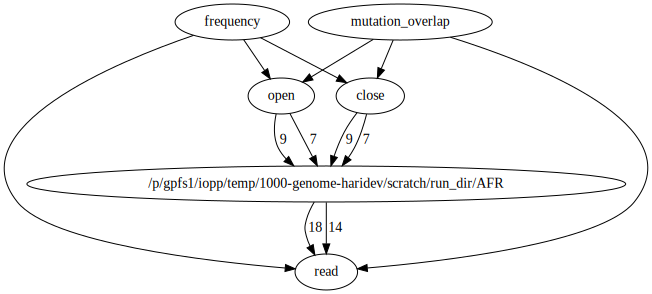

In [69]:
dot

In [70]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    if len(independent_files) > selected_index:
        selected_file = independent_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

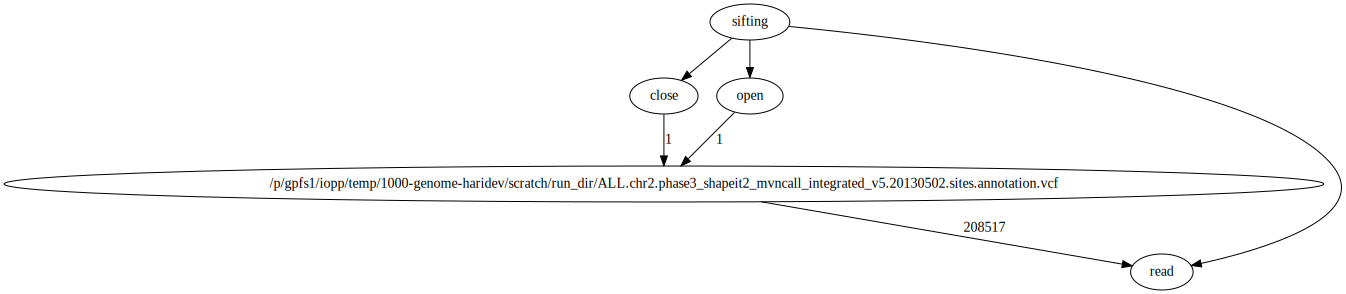

In [71]:
dot

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [72]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Select files which have no seeks and those which have

In [73]:
files_with_seek = io_ddf[io_ddf['func_id'].str.contains('seek') & io_ddf['filename'].str.contains('/p/gpfs')]['filename'].unique().compute()
print("{} files have seek operations".format(len(files_with_seek)))

0 files have seek operations


In [74]:
files_with_seek

Series([], Name: filename, dtype: object)

In [75]:
all_filenames

0           /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
1           /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
2           /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
3           /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
4           /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
                                  ...                        
10662470    /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
10662471    /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
10662472    /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
10662473    /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
10662474    /p/gpfs1/iopp/temp/1000-genome-haridev/scratch...
Name: filename, Length: 10662475, dtype: object

In [76]:
files_without_seek = set(all_filenames) - set(files_with_seek)
print("{} files have no seek operations and hence are sequential".format(len(files_without_seek)))

10662475 files have no seek operations and hence are sequential


### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [53]:
per_file_size = io_ddf_read_write.groupby(['filename'])['size'].sum()
per_file_size = per_file_size / 1024.0/1024.0
per_file_size = per_file_size.sort_values(ascending=False)
per_file_size.head(5)

filename
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr1.250000.vcf     554598.640625
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr10.250000.vcf    467458.062500
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr5.250000.vcf     438346.648438
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr7.250000.vcf     426236.250000
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr2.250000.vcf     414119.250000
Name: size, dtype: float64

In [54]:
per_file_time = io_ddf_read_write.groupby(['filename'])['duration'].sum().sort_values(ascending=False)
per_file_time.head(5)

filename
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr10.250000.vcf    1032.061646
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr7.250000.vcf     1024.783936
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr8.250000.vcf      977.636719
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr9.250000.vcf      903.396118
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr6.250000.vcf      833.193481
Name: duration, dtype: float32

In [55]:
per_file_bw = io_ddf_read_write.groupby(['filename'])['bandwidth'].sum().sort_values(ascending=True)
per_file_bw.head(5)

filename
/g/g92/haridev/.cache/matplotlib/fontlist-v330.json                                0.0
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpf6tkhxlm/chr3.HG02496    0.0
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpf6tkhxlm/chr3.HG02497    0.0
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpf6tkhxlm/chr3.HG02501    0.0
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpf6tkhxlm/chr3.HG02502    0.0
Name: bandwidth, dtype: float64

In [56]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_size.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        if "read" in func_id or "write" in func_id:
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            elif "write" in func_id:
                dot.edge(func_id,selected_file, label=str(count))

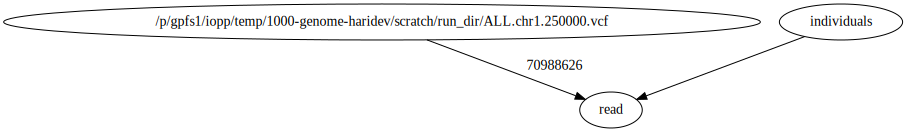

In [57]:
dot

In [58]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_time.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

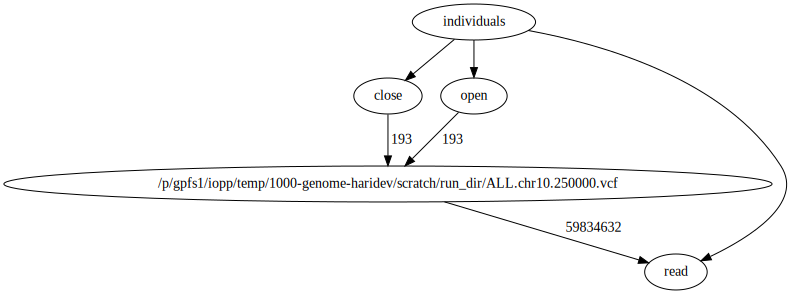

In [59]:
dot

In [60]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(5)
for selected_index in selected_indices:
    selected_file = per_file_bw.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

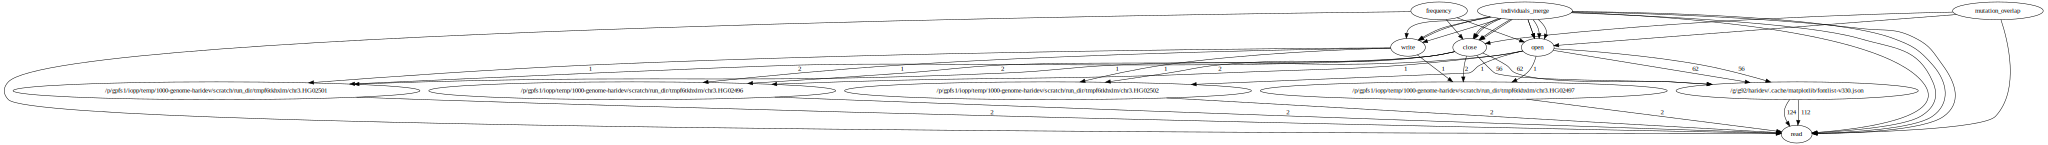

In [61]:
dot

In [62]:
write_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('write')]['filename'].unique()
read_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('read')]['filename'].unique()
read_only_files = set(all_filenames) - set(write_files)
write_only_files = set(all_filenames) - set(read_files)
print("{} files are written into.\n{} file are read from.\n{} files are write-only.\n{} file are read-only."
      .format(len(write_files), len(read_files), len(write_only_files), len(read_only_files)))

10488946 files are written into.
10592921 file are read from.
118 files are write-only.
104092 file are read-only.


In [63]:
print(read_only_files)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [64]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(read_only_files)].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file)

filename
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/AFR                              0.123444
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL                              0.453981
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr1.250000.vcf         554598.640625
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr10.250000.vcf        467458.062500
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/ALL.chr2.250000.vcf         414119.250000
                                                                                       ...      
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpzypa_5yz/chr1.NA21117         0.007812
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpzypa_5yz/chr1.NA21128         0.007812
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpzypa_5yz/chr1.NA21137         0.007812
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/tmpzypa_5yz/chr1.NA21142         0.007812
/p/gpfs1/iopp/temp/10

In [65]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(write_files) & io_ddf_read_write['func_id'].str.contains("write")].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file.head(20))

filename
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq.tar.gz                                                                 19.319469
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogram_mutation_overlap_chr1_sNO-SIFT_AFR_0.txt       0.000284
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogram_mutation_overlap_chr1_sNO-SIFT_AFR_1.txt       0.000283
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogram_mutation_overlap_chr1_sNO-SIFT_AFR_10.txt      0.000285
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogram_mutation_overlap_chr1_sNO-SIFT_AFR_100.txt     0.000286
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogram_mutation_overlap_chr1_sNO-SIFT_AFR_101.txt     0.000284
/p/gpfs1/iopp/temp/1000-genome-haridev/scratch/run_dir/chr1-AFR-freq/output_no_sift/Histogr